In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramNegSampling, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)
        self.out_embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, center_words, pos_context_words, neg_context_words):
        center_embeds = self.in_embed(center_words)
        pos_embeds = self.out_embed(pos_context_words)
        neg_embeds = self.out_embed(neg_context_words)

        pos_score = torch.sum(center_embeds * pos_embeds, dim=1)
        pos_loss = F.logsigmoid(pos_score)

        neg_score = torch.bmm(neg_embeds.neg(), center_embeds.unsqueeze(2)).squeeze(2)
        neg_loss = F.logsigmoid(neg_score).sum(1)

        loss = -(pos_loss + neg_loss).mean()
        return loss

In [ ]:
# load model
checkpoint = torch.load('checkpoint_epoch_nltk5.pt', map_location=torch.device('cuda'))

vocab_size = checkpoint['vocab_size']
embedding_dim = checkpoint['embedding_dim']

model = SkipGramNegSampling(vocab_size, embedding_dim)

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

embeddings = model.in_embed.weight.data 


C:\Temp\ipykernel_13332\2594642887.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_epoch_nltk5.pt', map_location=torch.device('cuda')

In [ ]:
# FOR NEWOUTPUT.TXT
from nltk.tokenize import word_tokenize
from collections import Counter
import re

max_bytes = 60 * 1024 * 1024

with open('new_output.txt', 'rb') as f:
    raw_bytes = f.read(max_bytes)

text = raw_bytes.decode('utf-8', errors='ignore')

chunk_size = 10_000_000 
chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

def stream_nltk_tokens(text_chunks):
    for chunk in text_chunks:
        tokens = word_tokenize(chunk.lower(), preserve_line=True)
        for token in tokens:
            if token.isalpha():
                yield token

word_counts = Counter()
print("Tokenizing chunks with NLTK...")

for i, token in enumerate(stream_nltk_tokens(chunks)):
    word_counts[token] += 1
    if i % 1_000_000 == 0:
        print(f"{i:,} tokens processed")

print("Tokenization complete!")
print(f"Unique words: {len(word_counts)}")

min_freq = 5
max_vocab_size = None

def is_clean_word(word):
    return re.fullmatch(r"[a-z]+", word) is not None

cleaned_word_counts = {
    word: freq for word, freq in word_counts.items()
    if is_clean_word(word) and freq >= min_freq
}



Tokenizing chunks with NLTK...
0 tokens processed
1,000,000 tokens processed
2,000,000 tokens processed
3,000,000 tokens processed
4,000,000 tokens processed
5,000,000 tokens processed
6,000,000 tokens processed
7,000,000 tokens processed
8,000,000 tokens processed
9,000,000 tokens processed
Tokenization complete!
Unique words: 158483


In [2]:
# for nltk
word_to_idx = {word: idx for idx, word in enumerate(cleaned_word_counts)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}


print(f"Final cleaned vocab size: {len(word_to_idx)}")
print("Sample vocab entries:", list(word_to_idx.items())[:10])

Final cleaned vocab size: 45700
Sample vocab entries: [('are', 0), ('you', 1), ('a', 2), ('resident', 3), ('of', 4), ('pinnacle', 5), ('who', 6), ('owns', 7), ('small', 8), ('business', 9)]


In [92]:
import pickle

with open("word_to_idx.pkl", "wb") as f:
    pickle.dump(word_to_idx, f)

with open("idx_to_word.pkl", "wb") as f:
    pickle.dump(idx_to_word, f)

In [87]:
word = 'queen'
if word in word_to_idx:
    word_idx = word_to_idx[word]
    word_vector = embeddings[word_idx]
    print(f"Embedding for '{word}':\n{word_vector}")
else:
    print(f"Word '{word}' not found in vocabulary.")


Embedding for 'queen':
tensor([-3.6221e-02,  4.6474e-01, -4.6045e-01,  3.2859e-01, -2.1072e-01,
         4.8157e-01,  1.0814e-01, -1.7645e-01,  1.6817e-01, -1.4249e-01,
        -2.9407e-01,  2.7971e-02, -1.4551e-01,  8.3918e-02, -3.1995e-02,
        -2.2585e-01,  5.4824e-02, -2.6597e-03, -2.2789e-02,  2.5730e-02,
        -2.2354e-04, -4.8014e-02, -1.6811e-01, -7.6494e-01,  4.9077e-01,
         5.6708e-01, -1.8327e-01,  4.9210e-01,  1.0593e-01, -1.4993e-01,
         3.2491e-02,  8.7955e-02, -3.7447e-01, -5.5665e-02, -1.6520e-03,
        -1.5840e-02, -4.5704e-01,  3.9949e-02,  8.4860e-01,  4.7197e-01,
        -4.4371e-01,  3.8932e-01, -1.4003e-01,  2.2057e-01,  5.0567e-01,
         4.9414e-01, -4.5644e-01, -3.0869e-03, -1.1814e-01, -1.2176e-01,
        -3.4573e-02,  1.0614e-01,  1.6918e-01, -2.1860e-01, -9.5903e-02,
        -3.1429e-01, -5.8567e-01, -1.7675e-01, -3.0623e-02, -3.2032e-01,
        -5.2579e-01, -4.3684e-01, -3.1100e-03,  3.8498e-01, -4.7010e-02,
        -2.0920e-01,  1.6029

In [ ]:
def find_nearest_words(target_word, embeddings, word_to_idx, idx_to_word, top_k=5):
    if target_word not in word_to_idx:
        print(f"Word '{target_word}' not found in vocabulary.")
        return []
    
    # Get the embedding vector for the target word
    target_idx = word_to_idx[target_word]
    target_vec = embeddings[target_idx]
    
    # Normalize embeddings to unit vectors
    normalized_embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    normalized_target = target_vec / target_vec.norm()

    # Compute cosine similarities
    similarities = torch.matmul(normalized_embeddings, normalized_target)

    # Get top k most similar words (including the word itself)
    top_k_similarities, top_k_indices = similarities.topk(top_k + 1)
    nearest_words = []
    for idx, sim in zip(top_k_indices[1:], top_k_similarities[1:]):  # skip first (itself)
        word = idx_to_word[idx.item()]
        nearest_words.append((word, sim.item()))

    return nearest_words


In [89]:
nearest_words = find_nearest_words('king', embeddings, word_to_idx, idx_to_word, top_k=20)

for word, similarity in nearest_words:
    print(f"{word}: {similarity:.4f}")


raider: 0.3253
queen: 0.2903
upped: 0.2778
vernon: 0.2764
dublin: 0.2689
cole: 0.2687
asha: 0.2573
almighty: 0.2559
alessandro: 0.2554
reread: 0.2533
bottomed: 0.2526
cuero: 0.2517
whispered: 0.2503
mirage: 0.2477
jin: 0.2472
probati: 0.2452
mediterranean: 0.2440
philistines: 0.2432
benson: 0.2429
protested: 0.2419


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_word_embeddings(words, embeddings, word_to_idx):
    valid_words = [word for word in words if word in word_to_idx]
    
    if not valid_words:
        print("No valid words found in vocabulary.")
        return
    
    vectors = torch.stack([embeddings[word_to_idx[word]] for word in valid_words])

    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors.cpu().numpy())

    plt.figure(figsize=(10, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

    for i, word in enumerate(valid_words):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

    plt.title("Word Embeddings Projected to 2D (PCA)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()


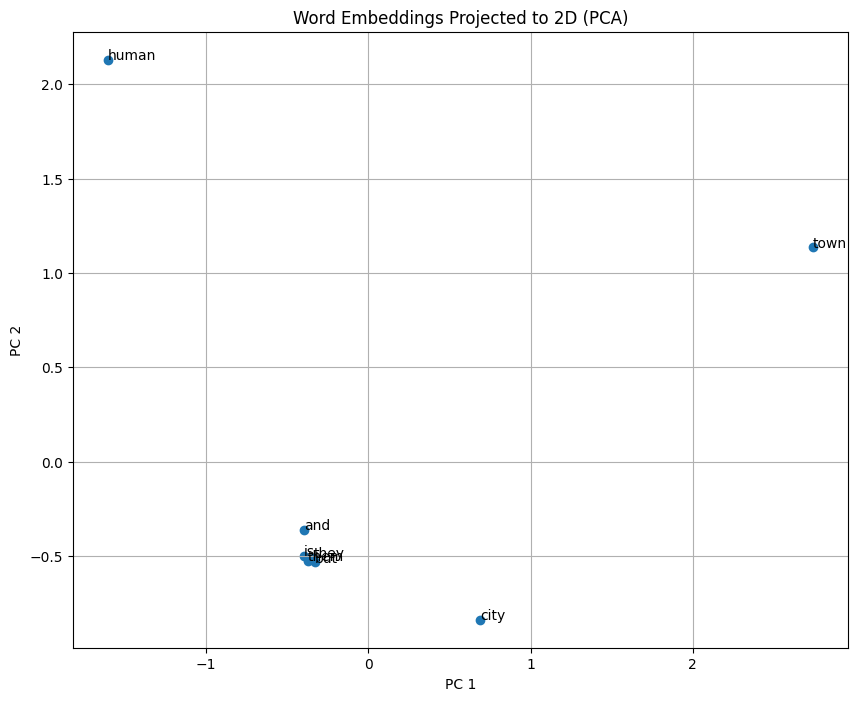

In [ ]:
words = ['is', 'and', 'they', 'them', 'but', 'human', 'town', 'city', 'sex']

plot_word_embeddings(words, embeddings, word_to_idx)


In [69]:
import numpy as np
import torch

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


In [70]:
glove_embeddings = load_glove_embeddings('glove.6B.50d.txt')

In [81]:
from numpy.linalg import norm

def normalize_embeddings(embeddings):
    return {word: vec / norm(vec) for word, vec in embeddings.items()}

normalized_glove = normalize_embeddings(glove_embeddings)

def normalize_tensor_embeddings(embedding_matrix, idx_to_word):
    norms = embedding_matrix.norm(dim=1, keepdim=True)
    normalized_matrix = embedding_matrix / norms
    return {idx_to_word[i]: normalized_matrix[i] for i in range(len(idx_to_word))}

In [91]:
my_embeddings = normalize_tensor_embeddings(embeddings, idx_to_word)
# my_embedding = embeddings[word_to_idx['dog']]
def get_top_k(word, embeddings, k):
    if word not in embeddings:
        raise ValueError(f"'{word}' not found in embeddings.")
    
    target = embeddings[word]
    similarities = {
        other: np.dot(target, vec)
        for other, vec in embeddings.items() if other != word
    }
    top_k = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [w for w, _ in top_k[:k]]

def find_min_k_with_overlap(word, glove, custom, max_k=100):
    for k in range(1, max_k + 1):
        glove_top = set(get_top_k(word, glove, k))
        custom_top = set(get_top_k(word, custom, k))
        if glove_top & custom_top:  # intersection not empty
            return k, glove_top & custom_top
    return None, set()

k, overlap = find_min_k_with_overlap('king', glove_embeddings, my_embeddings)
print(f"First k with overlap: {k}")
print(f"Overlapping words: {overlap}")

words = ['king', 'queen', 'dog', 'cat', 'man', 'woman', 'girl', 'boy', 'computer', 'kingdom']
for word in words:
    k, overlap = find_min_k_with_overlap(word, glove_embeddings, my_embeddings)
    print(f"First k with overlap: {k}")
    print(f"Overlapping words: {overlap}")

C:\Temp\ipykernel_13332\289474658.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  other: np.dot(target, vec)


First k with overlap: 7
Overlapping words: {'queen'}
First k with overlap: 7
Overlapping words: {'queen'}
First k with overlap: 2
Overlapping words: {'king'}
First k with overlap: 4
Overlapping words: {'cat'}
First k with overlap: 1
Overlapping words: {'dog'}
First k with overlap: 4
Overlapping words: {'woman'}
First k with overlap: 4
Overlapping words: {'she'}
First k with overlap: 7
Overlapping words: {'boy'}
First k with overlap: 1
Overlapping words: {'girl'}
First k with overlap: 6
Overlapping words: {'software'}
First k with overlap: 43
Overlapping words: {'northern'}


In [84]:
def get_closest_words(word, glove, top_k=10):
    if word not in glove:
        raise ValueError(f"'{word}' not found in GloVe.")
    
    vec = glove[word]
    similarities = {
        other: np.dot(vec, other_vec) / (norm(vec) * norm(other_vec))
        for other, other_vec in glove.items() if other != word
    }
    sorted_similar = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similar[:top_k]

closest_words = get_closest_words("king", glove_embeddings, top_k=10)
for word, sim in closest_words:
    print(f"{word}: {sim:.4f}")


prince: 0.8236
queen: 0.7839
ii: 0.7746
emperor: 0.7736
son: 0.7667
uncle: 0.7627
kingdom: 0.7542
throne: 0.7540
brother: 0.7492
ruler: 0.7434
